# Session RA-LAB01: Radio Obsevation Simulation

## I. Project description
<ins>Lecturer</ins>: Bang Nhan (NRAO)

<ins>Topic</ins>: Galactic neutral hydrogen (HI) radio sky simulation

<ins>Motivations</ins>:
This exercise will illustrate how one can simulate the Galactic radio signal at a given frequency based on publicly avaiable sky maps. This is normally the first needed step to help designing and evaluating the performance of a radio telescope. 

Through this simulation obesrvation simulation, one can incorporate additional simulation modules representing the instrumental effects to evaluate their impacts on the instrument's detection sensitivity before actually building and deploying the instrument to the field. 

This is the first exercise of the series for the Sagi's instrumentation summer school. We will be building on top of the skills we learn as the summer school progresses, eventually all come together to help you work on your simple radio telescope project. 

<ins>Learning objectives</ins>:
1. This exercise is to familiar you to how to read in radio survey sky map from the NASA data archive
2. Learn how to manipulate the sky map data and rotate it to an observer's local Longitude and Latitude coordinate
3. Simulate drift scan for the sky map over 24 hours in Local Sidereal Time (LST)
4. Simulate the sky power measured by a simple antenna beam after 24 hours LST

## II. Import common and installed Python libraries

In [1]:
# To make inline plot in Jupyter cells
%matplotlib inline 

# Import built-in python libraries
import os
import sys
import numpy as np
import struct
import pdb # Debugger
import re # For Regular expression operations like splitting strings
from glob import glob # For finding existing files in a given directory

# For time:
import time
from datetime import datetime, timedelta, date 

# Import additional packages provided in the environment.yml
import h5py # for handling HDF5 data format
import pickle as pk 

import healpy as hp # For handling HealPix data # Not available for Window OS
# (Ref: https://healpy.readthedocs.io/en/1.14.0/)
# If healpy not working, try pandas https://easy.gems.dkrz.de/Processing/healpix/healpix_starter.html

from tqdm import tqdm # For progress bar for loops

# For plotting:
import matplotlib.pyplot as plt  
import matplotlib.dates as mdates  # For datetime format in plots
# Set white background
plt.rcParams['figure.facecolor']='w'
plt.rcParams['savefig.facecolor']='w'
plt.rcParams['figure.figsize']=(10,7) # Set figure size

# For signal processing and analysis
import pandas as pd # For data science Pandas library

# For astronomy related functions (coordinate transform, physical units, etc)
from astropy import time as apTime
from astropy import constants as apConst
from astropy import units as u
from astropy.coordinates import SkyCoord, ITRS, angular_separation
from astropy.coordinates import TEME, CartesianDifferential, CartesianRepresentation
from astropy.coordinates import EarthLocation, AltAz

## III. Read in the Haslam sky map & coordinates data

The Haslam all-sky (all direction) survey map was made at 408 MHz by [Haslam et al. (1981)](http://ui.adsabs.harvard.edu/abs/1981A&A...100..209H) and [Haslam et al. 1982](http://ui.adsabs.harvard.edu/abs/1982A&AS...47....1H)

<ins>Extra</ins>: 
- The data file above can also be download from [this NASA webpage](https://lambda.gsfc.nasa.gov/product/foreground/fg_2014_haslam_408_get.html)
- Different versions of the Haslam map are available for download on [this NASA website](https://lambda.gsfc.nasa.gov/product/foreground/fg_2014_haslam_408_info.html)
- Other H1 21-cm survey maps on this [NASA's webpage](https://lambda.gsfc.nasa.gov/product/foreground/fg_diffuse.html)
- Other sky survey maps are also avaialble on the [NASA's website](https://lambda.gsfc.nasa.gov/product/)


### 1. Read in the Haslam map fits file:
(Ref: https://docs.astropy.org/en/stable/io/fits/index.html)

A copy of the sky map has been downloaded and stored in (we are using the Haslam 408 MHz with no filtering version:
>`sagi/radio_astronomy/session_RA-LAB-01/data/lambda_haslam408_nofilt.fits`

In [8]:
from astropy.io import fits
#file_dir = 'session_RA-LAB-01/data/'
file_dir = 'data'
file_name = 'lambda_haslam408_nofilt.fits'

In [9]:
# Determine if there is a file in the directory
current_dir = os.getcwd() # Current jupyter notebook directory
fits_image_filename = glob(os.path.join(current_dir[:-5],
                                        file_dir,
                                        file_name))
print(fits_image_filename)
# Check if the file exists in the directory:
if len(fits_image_filename) == 0:
    raise ValueError("Missing Haslam map, please check")

['/home/bnhan/Documents/research/projects/summer_school/3s24_summer_school/sagi_bnhan_radio/session_RA-LAB-01/data/lambda_haslam408_nofilt.fits']


In [10]:
# Should be only one file, so reset the fits_image_filename from a list ot string
fits_image_filename = fits_image_filename[0]

In [11]:
# Open & explore the fits file as an HDUList objects:
with fits.open(fits_image_filename) as hdul:
    hdul.info()
    haslam_map = hdul[1].data # Read out the data into a new variable

Filename: /home/bnhan/Documents/research/projects/summer_school/3s24_summer_school/sagi_bnhan_radio/session_RA-LAB-01/data/lambda_haslam408_nofilt.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      30   ()      
  1  Archive Map Table    1 BinTableHDU     24   3145728R x 2C   [1E, 1E]   


In [12]:
hdul

[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7fd116e3f7d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7fd118437d90>]

In [13]:
# Check the HDUList data's header for other information about the sky map:
# Or look up on the NASA website:
# https://lambda.gsfc.nasa.gov/cgi-bin/fitsheader.cgi?fitsfile=%2Fdata%2Fforegrounds%2Fhaslam%2Flambda_haslam408_nofilt.fits
hdul[0].header, hdul[1].header

(SIMPLE  =                    T / file does conform to FITS standard             
 BITPIX  =                    8 / number of bits per data pixel                  
 NAXIS   =                    0 / number of data axes                            
 EXTEND  =                    T / FITS dataset may contain extensions            
 COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
 COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
 DATE    = '2012-04-03T00:00:00' /file creation date (YYYY-MM-DDThh:mm:ss UT)    
 OBJECT  = 'ALL-SKY '           / Portion of sky given                           
 COMMENT   This file contains data from the Haslam 408 MHz radio continuum       
 COMMENT   sky survey.  The survey data were downloaded from the Max Planck      
 COMMENT   Institute for Radioastronomy Survey Sampler website and interpolated  
 COMMENT   to HEALPix projection with Nside=512. No filtering or other processing
 COMMENT   was a

In [6]:
# Check the data structure of the Haslam map data:
# The map should be stored in Healpix format with length of 3145728, 
# this corresponding to nside of 512, 12*(nside)**2 = npix,
# Can check with function: npix = hp.nside2npix(nside), or nside = hp.npix2nside(npix)


FITS_rec([(190822.9 , 1.), (189548.52, 1.), (189546.58, 1.), ...,
          (183922.45, 1.), (181827.77, 1.), (183828.95, 1.)],
         dtype=(numpy.record, [('TEMPERATURE', '>f4'), ('N_OBS', '>f4')]))

### 2. Read in the Haslam map's coodinate maps $(\theta, \phi)$ fits file:
Download from [this NASA's website](https://lambda.gsfc.nasa.gov/toolbox/pixelcoords.html)

A copy of the sky map's cooridnate map has been downloaded and stored in (we are using the Nested, Nside =512, Galactic coodinates version):
>`sagi/radio_astronomy/session_RA-LAB-01/data/ 	pixel_coords_map_nested_galactic_res9.fits`

In [18]:
file_dir = 'data'
file_name = 'pixel_coords_map_nested_galactic_res9.fits'
current_dir = os.getcwd() # Current jupyter notebook directory
fits_image_filename = glob(os.path.join(current_dir[:-5],
                                        file_dir,
                                        file_name))
print(fits_image_filename)

['/home/bnhan/Documents/research/projects/summer_school/3s24_summer_school/sagi_bnhan_radio/session_RA-LAB-01/data/pixel_coords_map_nested_galactic_res9.fits']


In [19]:
with fits.open(fits_image_filename[0]) as hdul:
    hdul.info()
    haslam_coord_map = hdul[1].data

Filename: /home/bnhan/Documents/research/projects/summer_school/3s24_summer_school/sagi_bnhan_radio/session_RA-LAB-01/data/pixel_coords_map_nested_galactic_res9.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      21   ()      
  1                1 BinTableHDU     21   3145728R x 2C   [E, E]   


In [20]:
haslam_coord_map

FITS_rec([( 45.     ,  0.0746039 ), ( 45.08789,  0.14920793),
          ( 44.91211,  0.14920793), ..., (315.0879 , -0.14920793),
          (314.9121 , -0.14920793), (315.     , -0.0746039 )],
         dtype=(numpy.record, [('LONGITUDE', '>f4'), ('LATITUDE', '>f4')]))

In [21]:
# Rename the data arrays into variable
haslam_map_gal = haslam_map['TEMPERATURE']
theta_haslam = haslam_coord_map['LATITUDE']
phi_haslam = haslam_coord_map['LONGITUDE']

### 3. Convert Nested to Ring format for healpix data 
(seems to be less buggy to work with Ring data)

In [22]:
haslam_map_gal = hp.reorder(haslam_map_gal,n2r=True)
theta_haslam = hp.reorder(theta_haslam,n2r=True)
phi_haslam = hp.reorder(phi_haslam,n2r=True)


## IV. Plot the Haslam map with healpy

### 1. Plot in Mollweide Projection:
(Ref: https://healpy.readthedocs.io/en/latest/generated/healpy.visufunc.mollview.html#healpy.visufunc.mollview)

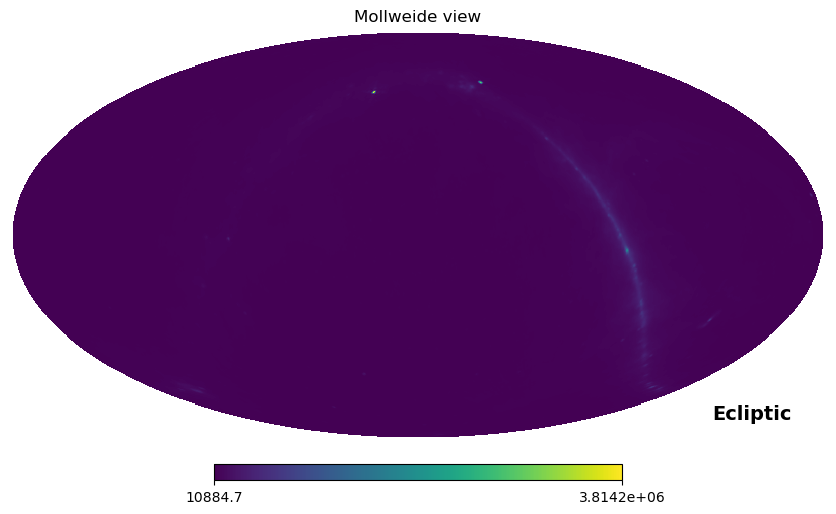

In [23]:
# Plot the haslam map with healpy in Mollweide projection:
# The sky brightness temperature is in millikelvin (see header above)
# data is in NESTED Healpix format, need to set kwarg nest to True
#  coord=["G", "E"] is to convert from Galactic to Equatorial coordinate
hp.mollview(haslam_map['TEMPERATURE'],nest=True, coord=["G", "E"])  # in linear scale


#### Exercise: Which scale (linear vs logarithmic) show the data better?

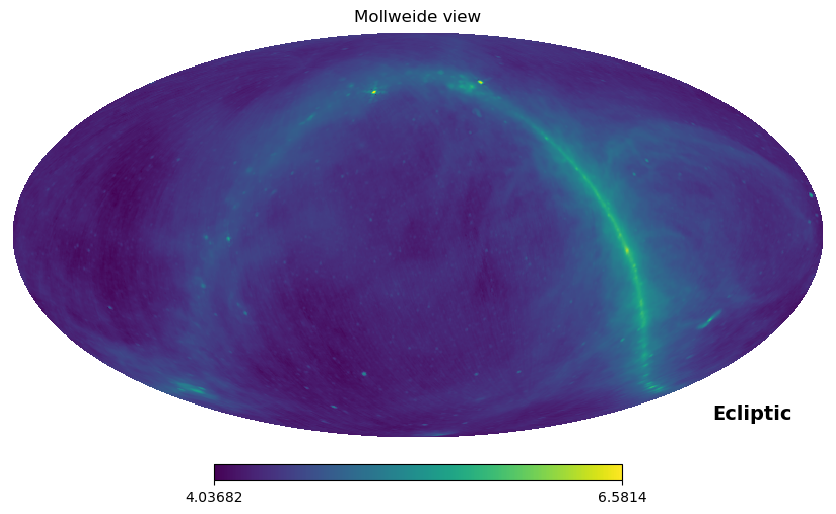

In [136]:
hp.mollview(np.log10(haslam_map['TEMPERATURE']),nest=True, coord=["G", "E"]) # in log10 scale (Give it a try)

### 2. Plot in Cartesean Projection:
(Ref: https://healpy.readthedocs.io/en/latest/generated/healpy.visufunc.cartview.html#healpy.visufunc.cartview)

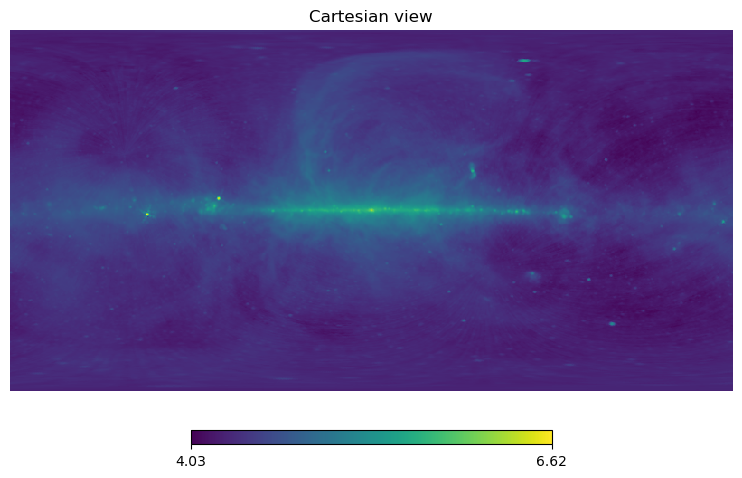

In [66]:
hp.cartview(np.log10(haslam_map_gal))#,nest=True)

### 3. Plot in Orthographic Projection:
(Ref: https://healpy.readthedocs.io/en/latest/generated/healpy.visufunc.orthview.html#healpy.visufunc.orthview)

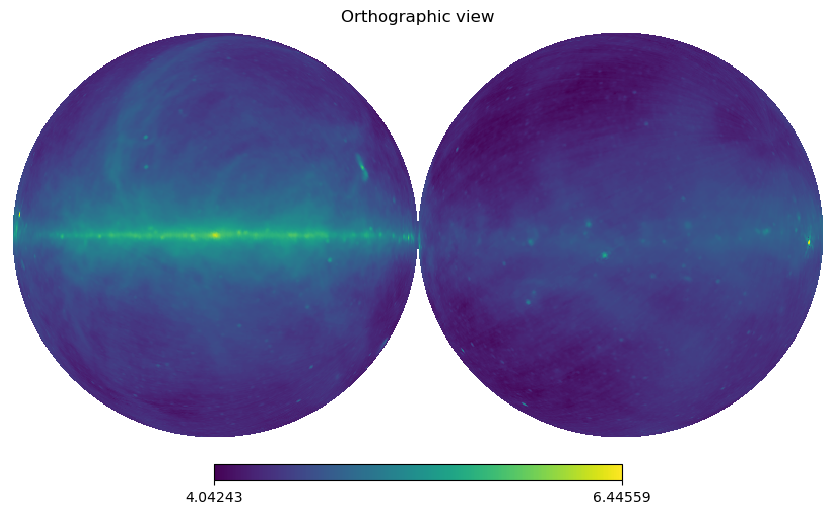

In [67]:
hp.orthview(np.log10(haslam_map_gal))

#### Exercise: Rotate the sky map around

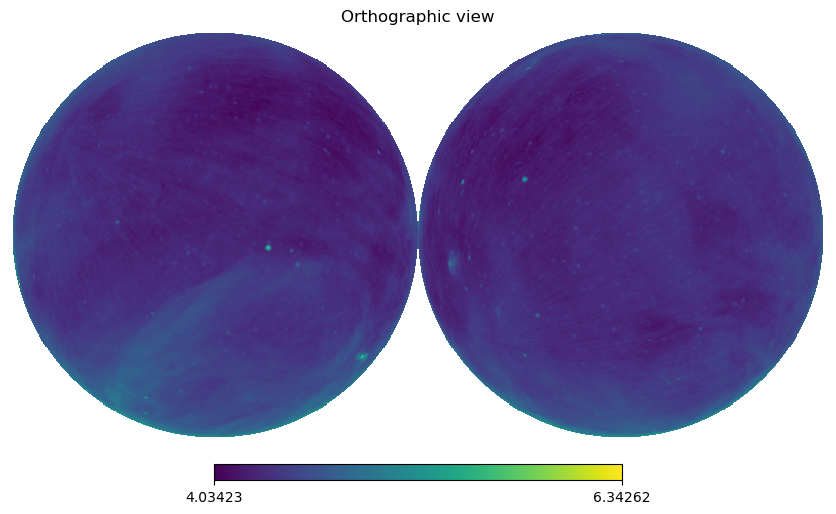

In [69]:
# Need to rotate the sky map to the correct orientation for a give observer's position on earth. 
# We will use the built-in rotator argument to do that 
# (Feel free to change the angles to see how the plot change)

hp.orthview(np.log10(haslam_map_gal),rot=(0,90))
#hp.orthview(np.log10(haslam_map_gal),rot=(90,0))
#hp.orthview(np.log10(haslam_map_gal),rot=(90,90))

## V. Manipulate the Haslam map

### 1. Change the Healpix beam map spatial resolution
Raw Haslam map has nside = 512 (with angular resolution of a pixel = deg) or number of pixels = . 

To make simulation faster, we can reduce the spatial resolution of the map by interpolate to lower nside (or large angular resolution) with the healpy function ud_grade (https://healpy.readthedocs.io/en/latest/generated/healpy.pixelfunc.ud_grade.html)

In [24]:
# Ref: (https://healpy.readthedocs.io/en/latest/generated/healpy.pixelfunc.ud_grade.html
nside_sim = 128 #(max = 512) , any other power of two from 4, 8, 16,32,.. works
haslam_map_new = hp.ud_grade(haslam_map_gal,
                             nside_out=nside_sim,
                             order_in='RING',
                             power=-2)

#### Exercise: Plot the new and old Haslma maps with one of the plotting projections above to see how different the two Haslam maps look like

In [37]:
Student make plots for different nside_sim

### 2. Align the sky map to where the observer 

The Haslam map is stored in Galactic coordinate, so doesn't know where the observer is on Earth. We need to align the Haslam map to the observer's Longitude and Latitude

#### 2.1 Determine the observation site coordinate for the observer

In [25]:
# Determine the observer's Longitude & Latitude
# (Can use Google map to help determine Lon & Lat by right click a location on the map)

# Student's exercise!!! 
# (Fill in the three variable for your location, we will pick ICISE in Quy Nhon for today)
# Example: Nha Trang Observatory's (Lat,Lon) = (12.271, 109.205)
obs_lat = 12.271 # [degree]
obs_lon = 109.205 # [degree]
obs_elevation = 0. #[m]

#### Exercise: Determine the Lon & Lat of the ICISE site with Google Map

In [ ]:
'''
# Quy Nhon ICSISE site:
obs_lon = # [degree]
obs_lat = # [degree]
obs_elevation = # [m] Elevation above sea level
# can look up online, or if close to sea level, can set to 0
'''

In [26]:
# Create an Earth Location object from the Astropy library:
obs_site = EarthLocation(lat=obs_lat*u.deg,
                          lon=obs_lon*u.deg,
                          height=obs_elevation*u.m)

#### 2.2  Rotate the Haslam map to where we are

We will use the Rotator class introduced in Healpy above when doing plotting to align the Haslam map

Things to know: 
- The Equatorial Cooridnate is the North & South poles aligned with the Earth's geographical poles (Not magnetic poles)
- Longitude and Latitude are already on the same geographic coordinate

Ref: https://www.zonca.dev/posts/2021-03-11-rotate-maps-healpy.html

#### 2.2.1 First convert from Galatic to Equatorial coordinate

In [27]:
# Determine the theta and phi array for the existing Haslam map
# in Galactic coordinate:
n_pix  = hp.get_map_size(haslam_map_new)
theta_haslam_gal, phi_haslam_gal = hp.pix2ang(nside_sim, 
                                              np.arange(n_pix))

# Define the Healpy Rotator (from Galactic to Equatorial):
rot_g2e = hp.rotator.Rotator(coord=['G','E'],
                             inv=True) 

# Calculate the rotated coordinate arrays:
theta_haslam_eq, phi_haslam_eq = rot_g2e(theta_haslam_gal,
                                         phi_haslam_gal) 

# Fill out the rotated map's new indices with the original map values:
# (hp.ang2pix need radians, not degrees)
pix_rot = hp.ang2pix(nside_sim, 
                     theta_haslam_eq, 
                     phi_haslam_eq)
haslam_rotated_eq = haslam_map_new[pix_rot]


#### Exercise: Plot and check the rotated map:

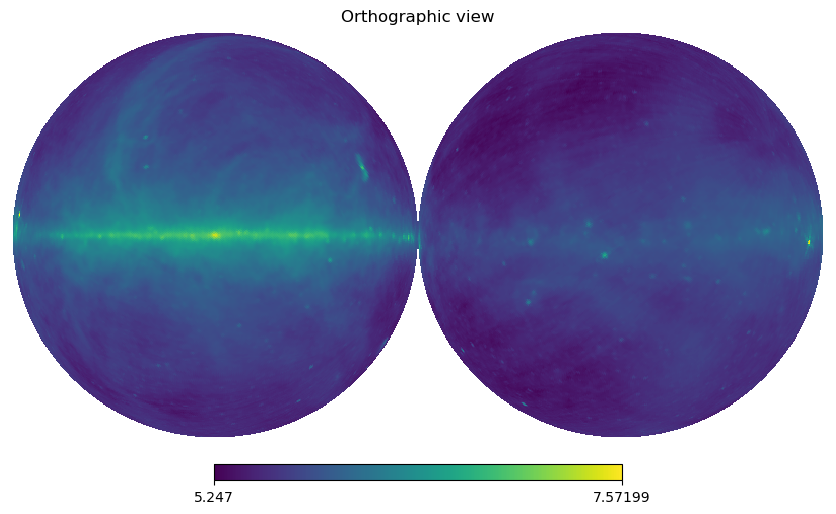

In [28]:
hp.orthview(np.log10(haslam_map_new))

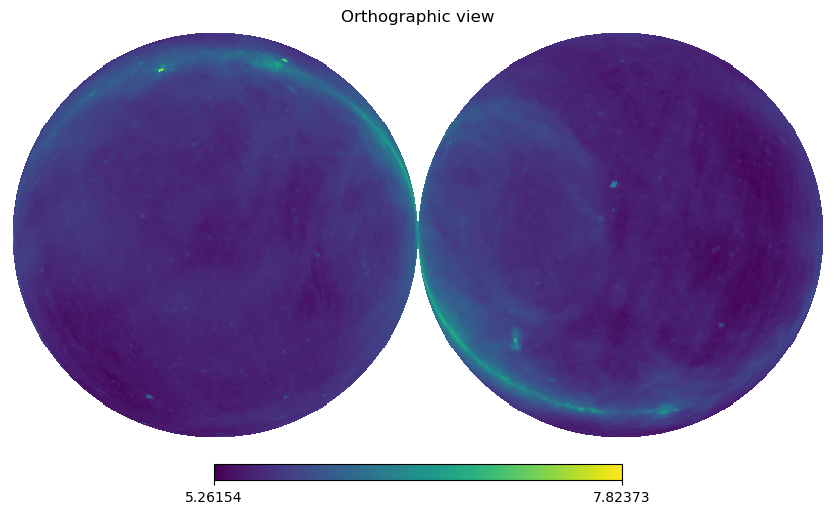

In [29]:
# Plot the rotated map using Rotator to rotate the Haslam map first
hp.orthview(np.log10(haslam_rotated_eq))

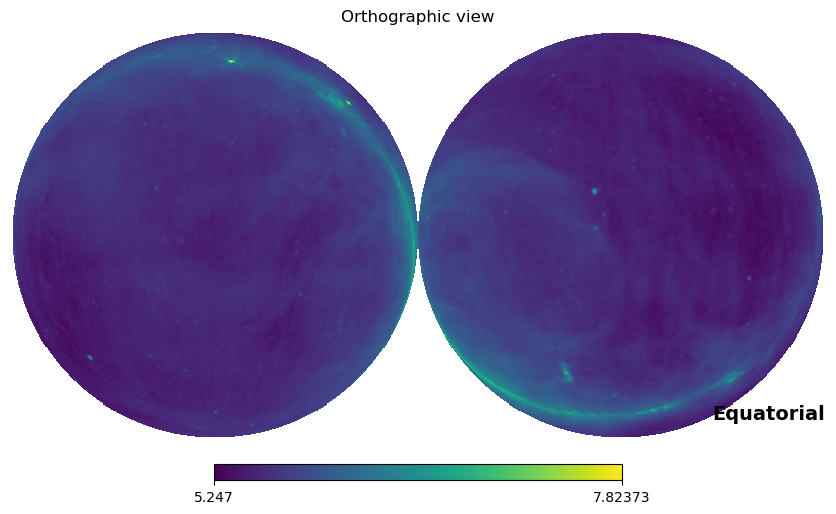

In [110]:
# Plotting the rotated by rotating the map in the plot function
# This method doesn't give us the sky array easily, good for visual checking
hp.orthview(np.log10(haslam_map_new),coord=['G','C'])

#### 2.2.2 Rotate Equatorial haslam map to the observer's Longitude and Latitude

In [ ]:
# One trick is to align sky map so the overhead angle (zenith) from the observer is facing out of the screen 
# Need to also rotate the cooridnate arrays to keep track of things:

In [30]:
# Create a local rotator function:
def sky_map_obs_rotate(map_in, theta_in, phi_in,
                       rot_lon_deg,rot_lat_deg,
                       nside_sim=128):
    '''
    This function will rotate the sky map (in equitorial coordinate) 
    to a local observer's overhead/zenith at the observer's Long Lat

    Parameters
    ----------
    map_in : ndarray (in Healpix format)
        Input sky map
    theta_in : ndarray
        Theta array of the input skymap [degree]
    phi_in : ndarray
        Phi array of the input skymap [degree]
    rot_lon_deg : float
        Longitude angle to rotate the sky map to
    rot_lat_deg : float
        Latitude angle to rotate the sky map to
        
    Returns
    -------
    map_out : ndarray (in Healpix format)
        Output Sky map at the observer's zenith
    '''
    # Define the Healpy Rotator (From Equatorial to local Observer's Lon & Lat):
    rot_obs = hp.rotator.Rotator(rot=[rot_lon_deg,rot_lat_deg],
                                 inv=True) 

    # Calculate the rotated coordinate arrays:
    theta_out, phi_out = rot_obs(theta_in,
                                 phi_in) 

    # Fill out the rotated map's new indices with the original map values:
    # (hp.ang2pix need radians, not degrees)
    pix_rot = hp.ang2pix(nside_sim, 
                         theta_out, 
                         phi_out)
    map_out = map_in[pix_rot]

    return map_out, theta_out, phi_out

In [31]:
# Run the rotation function to ge tthe new sky map
haslam_rotated_obs, theta_obs, phi_obs = sky_map_obs_rotate(haslam_rotated_eq,
                                                            theta_haslam_eq,
                                                            phi_haslam_eq,
                                                            obs_site.lon.value,
                                                            obs_site.lat.value,
                                                            nside_sim = nside_sim)
                                        

#### Exercise: Plot inspect rotated map

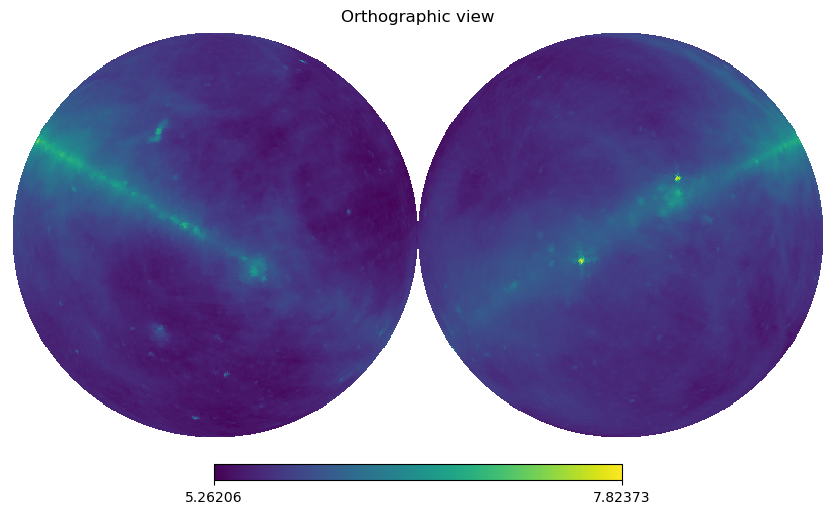

In [32]:
hp.orthview(np.log10(haslam_rotated_obs))

## VI. Simulate drift scan for the sky map over 24 hours in Local Sidereal Time (LST)

For not moving the telescope, just pointing upward, the sky will change over time, which is called "drift" scan due to the Earth's rotation.

<ins>Tasks</ins>: Students will learn how to rotate the sky map for different LST time, knowing that for 24 hr LST, it's 360 deg, so 1 hr *(360 deg/24 hr) = 15 deg

### 1. Generate UTC time array for the observation

In [33]:
#t_utc_start = datetime.now() # Assume today now
t_utc_start = datetime(2024,7,24,0,0,0) # Pick a start UTC at 00:00:00 on 24/7/2024
t_utc_end = t_utc_start + timedelta(hours=24) # add 24 hours later

# Generate the UTC time array for the givenstar, end, and step size:
delta_t_min = 60 # [min] Step size of the array in minutes, must be integer

# dt = datetime
t_utc_dt =  np.arange(t_utc_start, t_utc_end, timedelta(minutes=delta_t_min)).astype(datetime)

### 2. Convert UTC to LST

In [34]:
# Convert UTC to LST with astropy:
# i) Convert the datetime t_utc to astropy.Time object first
# Ref: for astropy.Time.Time https://docs.astropy.org/en/stable/time/index.html
t_utc = apTime.Time(t_utc_dt,
                    format='datetime',
                    scale='utc',
                    location=obs_site)

In [35]:
# ii) Convert the astropy.Time object from UTC to LST
# There are two types of sidereal time: 'mean' vs 'apparent' 
# (https://en.wikipedia.org/wiki/Sidereal_time#Mean_and_apparent_varieties)
t_lst_mean = t_utc.sidereal_time('mean')
# t_lst_app = t_utc.sidereal_time('apparent')

#### Exercises: Compare LST and UTC
1. Print the t_lst and t_utc out and see what's the difference between them
2. Check what's different between t_lst_mean and t_lst_app

### 3. Rotate the sky map over LST time

We will use the Rotator class again to rotate the sky map every hours

Tips: 
- Used the aligned Haslam map, haslam_rotated
- Knowing that every 1 LST hour = 15 degree
- To make things easier to keep track of, we can align the beam and sky so it's zenith or boreisght is pointing out of the page when looking at hp.orthview by
- Rotate the haslam_rotated with rot=[180,90]


In [200]:
t_lst_mean.value

array([ 3.42769425,  4.43043217,  5.43317008,  6.43590799,  7.4386459 ,
        8.44138381,  9.44412173, 10.44685964, 11.44959755, 12.45233546,
       13.45507337, 14.45781128, 15.4605492 , 16.46328711, 17.46602502,
       18.46876293, 19.47150084, 20.47423875, 21.47697667, 22.47971458,
       23.48245249,  0.4851904 ,  1.48792831,  2.49066623])

In [36]:
# Define arrays to store and keep track of how the sky rotates:
sky_map_arr = np.zeros([len(t_lst_mean),hp.nside2npix(nside_sim)])
theta_map_arr = 0*sky_map_arr
phi_map_arr = 0*sky_map_arr

# Loop through 24 hours LST:
for tt in tqdm(range(len(t_lst_mean))):
    print("Running LST hour {:f}".format(t_lst_mean.value[tt]))
    # Assume the rotated map we had above is at LST = 0 hr
    if tt == 0:
        sky_map_arr[tt,:] = haslam_rotated_obs
        theta_map_arr[tt,:] = theta_obs 
        phi_map_arr[tt,:] = phi_obs 
    else:
        rot_lon_tt = tt*15.0
        rot_lat_tt = 0
        # Each new time step, we will rotate the sky by 15 deg in Longitude
        # We use the rotation function we wrote above 
        sky_map_arr[tt,:], theta_map_arr[tt,:],\
            phi_map_arr[tt,:] = sky_map_obs_rotate(sky_map_arr[0,:],
                                                   theta_map_arr[0,:],
                                                   phi_map_arr[0,:],
                                                   rot_lon_tt,
                                                   rot_lat_tt,
                                                    nside_sim = nside_sim)



  8%|███▌                                      | 2/24 [00:00<00:01, 15.93it/s]

Running LST hour 3.427694
Running LST hour 4.430432
Running LST hour 5.433170


 17%|███████                                   | 4/24 [00:00<00:01, 10.70it/s]

Running LST hour 6.435908
Running LST hour 7.438646


 25%|██████████▌                               | 6/24 [00:00<00:01,  9.98it/s]

Running LST hour 8.441384
Running LST hour 9.444122
Running LST hour 10.446860


 42%|█████████████████                        | 10/24 [00:00<00:01, 10.49it/s]

Running LST hour 11.449598
Running LST hour 12.452335
Running LST hour 13.455073


 50%|████████████████████▌                    | 12/24 [00:01<00:01, 10.25it/s]

Running LST hour 14.457811
Running LST hour 15.460549
Running LST hour 16.463287


 58%|███████████████████████▉                 | 14/24 [00:01<00:00, 10.11it/s]

Running LST hour 17.466025
Running LST hour 18.468763


 67%|███████████████████████████▎             | 16/24 [00:01<00:00, 10.01it/s]

Running LST hour 19.471501
Running LST hour 20.474239


 79%|████████████████████████████████▍        | 19/24 [00:01<00:00,  9.70it/s]

Running LST hour 21.476977
Running LST hour 22.479715


 88%|███████████████████████████████████▉     | 21/24 [00:02<00:00,  8.44it/s]

Running LST hour 23.482452
Running LST hour 0.485190


100%|█████████████████████████████████████████| 24/24 [00:02<00:00,  9.63it/s]

Running LST hour 1.487928
Running LST hour 2.490666


## VII. Simulate the sky power measured by a simple antenna beam after 24 hours LST

### 1. Generate a mock antenna beam

#### 1.1 Generate a 2D Gaussian function on spherical coordinate $(\theta,\phi)$

2D Gaussian (https://en.wikipedia.org/wiki/Gaussian_function)
$f(x,y) = A*\exp\{-\left[\frac{(x-x_0)^2}{2\sigma_x^2}+\frac{(y-y_0)^2}{2\sigma_y^2}\right]\}$

In [37]:
def gauss_kernel_2d(A=1.0, side_l=5, sig=1.):
    """\
    creates gaussian kernel with side length `l` and a sigma of `sig`
    Ref: https://copyprogramming.com/howto/how-to-calculate-a-gaussian-kernel-matrix-efficiently-in-numpy
    """
    ax = np.linspace(-(side_l - 1) / 2., (side_l - 1) / 2., side_l)
    gauss = np.exp(-0.5 * np.square(ax) / np.square(sig))
    kernel = np.outer(gauss, gauss)
    return A*kernel / np.sum(kernel)

In [38]:
theta_deg = np.arange(0,180,1)
theta_rad = np.radians(theta_deg)# Theta array [radians] (from 0 to 180 deg)
phi_deg = np.arange(0,360,1.)
phi_rad = np.radians(phi_deg)# Phi array [radians], from 0 to 360 deg

# Define the Beam Full width at half max (FWHM) & amplitude (or gain):
beam_fwhm_deg = 60. #[deg]
beam_gain = 1.0 # [linear unit, not dB], assuming unity gain, not need to correct later

# Compute the gaussian Sigma with FWHM:
# Ref: #https://en.wikipedia.org/wiki/Full_width_at_half_maximum
beam_sigma_deg = beam_fwhm_deg/(2*np.sqrt(2*np.log(2))) 

# Generate the 2D Gaussian Kernel (size = side_l x side_l):
gaussian_beam_2d_tmp = gauss_kernel_2d(A=beam_gain, 
                                       side_l=len(phi_rad),
                                       sig=beam_sigma_deg)

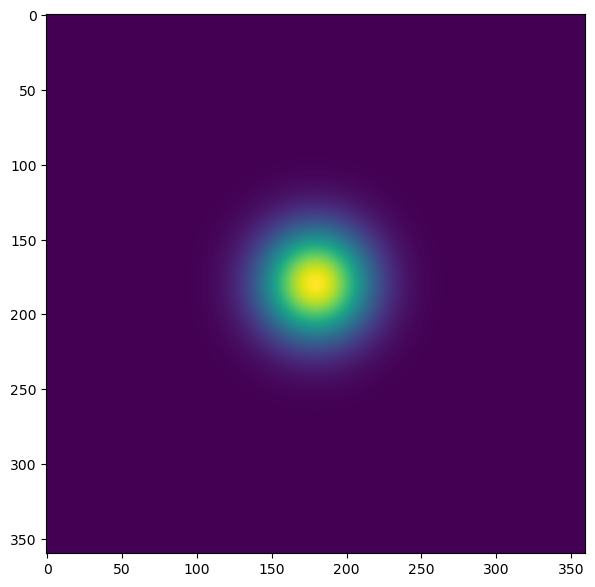

In [39]:
# Plot and Check the Gaussian profile
plt.imshow(gaussian_beam_2d_tmp)

#### Exercise: Try different width (sigma) of the Gaussian beam and plot them

In [40]:
# Reshape the 2d array of the Gaussian kernel so the upper hemisphere (theta = 0-90 deg is the beam)
# before converting into a healpix map:
# Need to be size of len(theta_rad) x len(phi_rad), 
# e.g., for 1-deg resolution, it's 180x360
gaussian_beam_2d = np.zeros([len(theta_rad),len(phi_rad)])
gaussian_beam_1d_profile = gaussian_beam_2d_tmp[180:,180]
# Create 2d profile in the right size by taking the 1d gaussian profile and rotate 360 deg
for pp in range(len(phi_rad)): 
    gaussian_beam_2d[:,pp] = gaussian_beam_1d_profile

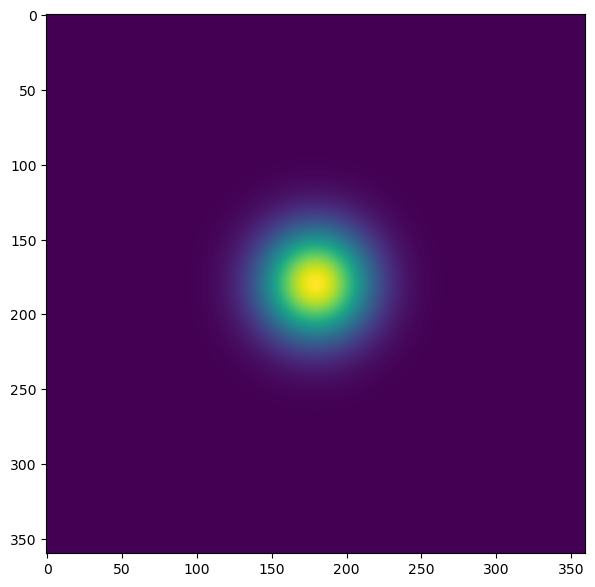

In [41]:
# Plot and Check the Gaussian profile
plt.imshow(gaussian_beam_2d_tmp)

Text(0.5, 1.0, 'FWHM = 60.00 deg')

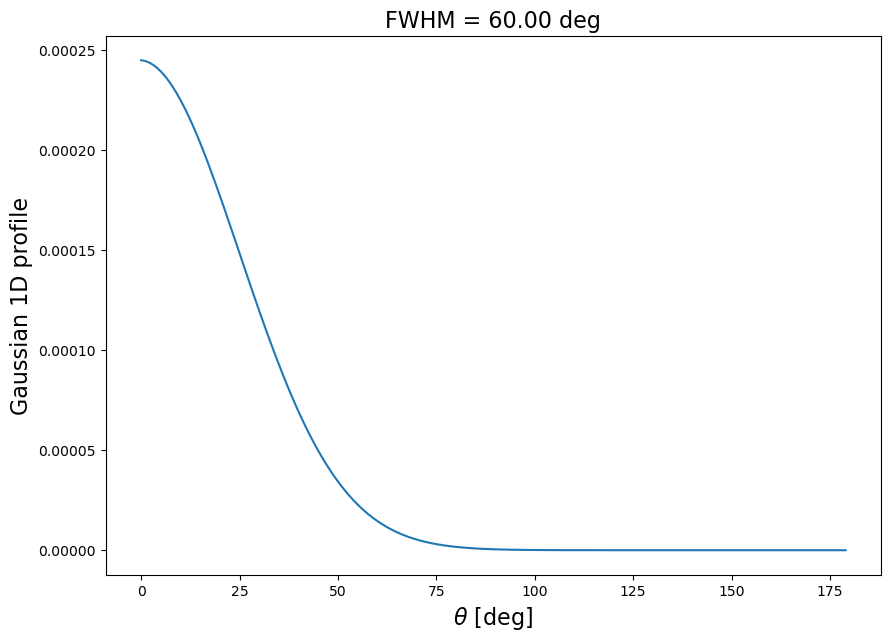

In [42]:
plt.plot(theta_deg,gaussian_beam_2d[:,0])
plt.xlabel(r'$\theta$ [deg]',fontsize=16)
plt.ylabel('Gaussian 1D profile',fontsize=16)
plt.title('FWHM = {:.2f} deg'.format(beam_fwhm_deg),fontsize=16)

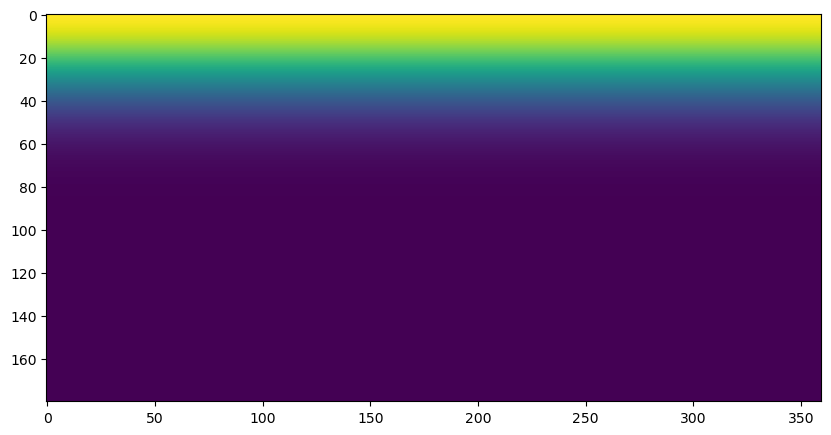

In [43]:
plt.imshow(gaussian_beam_2d)

#### 1.2 Convert the Gausisan beam from  spherical coordinate grid to Healpix

In [44]:
from scipy.interpolate import RectSphereBivariateSpline
# Ref: https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.RectSphereBivariateSpline.html
# We will use the RectSphereBivariateSpline function 
def spherical2d_to_healpix(data2d,
                           theta_2d_rad,
                           phi_2d_rad,
                           nside=512):
        '''
        This method will convert a given 2d array in spherical coordinate 
        in format of [theta x phi] into a healpix format
        
        Parameters
        ----------
        data2d : ndarray
        theta_2d_rad : ndarray
        phi_2d_rad : ndarray
        nside : int
        
        Returns
        -------
        data_hp : ndarray
            The output data in healpix format
        '''        
        npix = hp.nside2npix(nside)
        theta_hp, phi_hp = hp.pixelfunc.pix2ang(nside, np.arange(npix))
        
        # Note excluding the index since hte index at the poles are duplicates
        lut = RectSphereBivariateSpline(theta_2d_rad[1:-1],phi_2d_rad[:-1],data2d[1:-1,:-1]) 
        data_hp = lut.ev(theta_hp.ravel(),phi_hp.ravel())

        return data_hp, theta_hp, phi_hp


In [45]:
gaussian_beam_hp, theta_hp, phi_hp = spherical2d_to_healpix(gaussian_beam_2d,
                                                            theta_rad,
                                                            phi_rad,
                                                            nside=nside_sim)

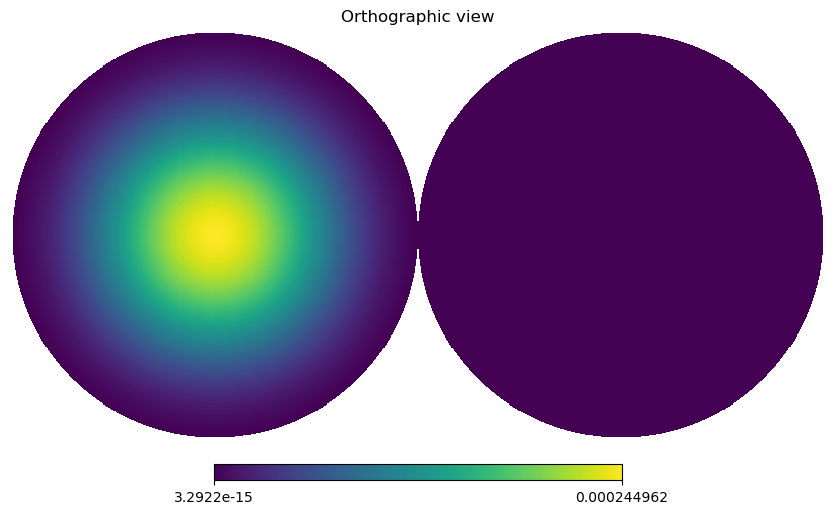

In [46]:
hp.orthview(gaussian_beam_hp,rot=(0,90)) 

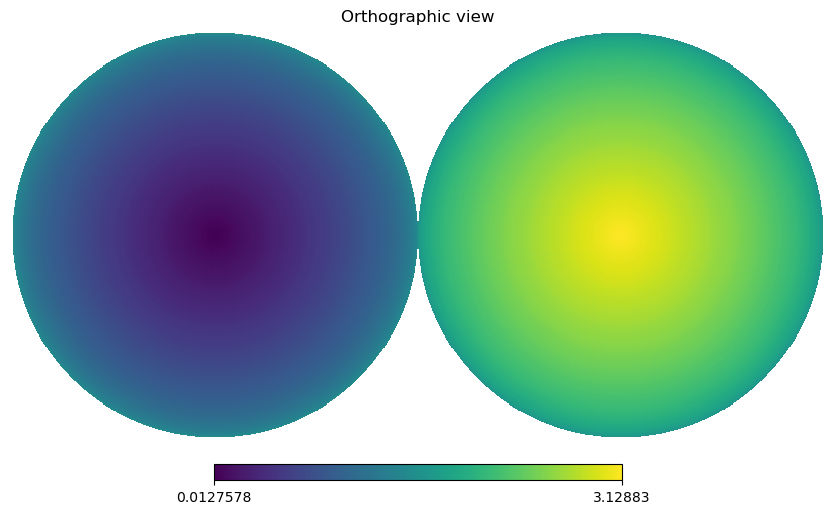

In [88]:
hp.orthview(theta_hp,rot=(0,90))

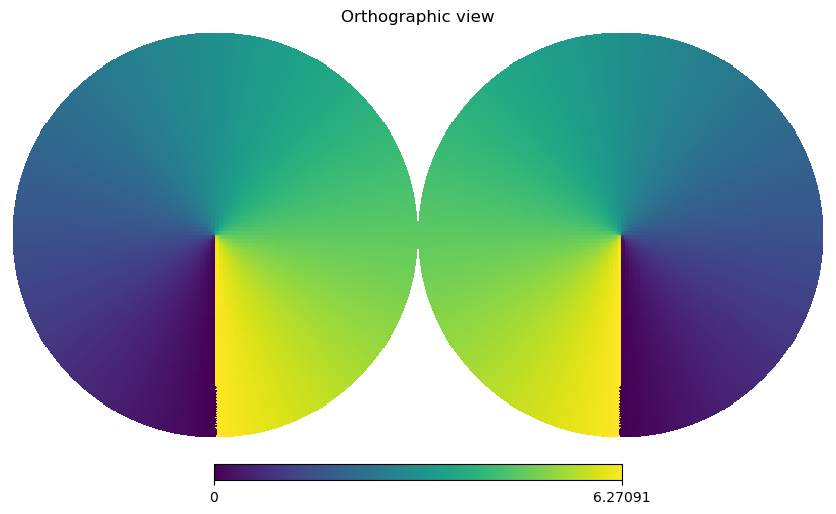

In [87]:
hp.orthview(phi_hp,rot=(0,90))

### 2. Calculate the beam-weighted antenna temperature at 408 MHz
(Ref: https://antenna-theory.com/basics/temperature.php)
$T_\mathrm{ant}(408 \mathrm{MHz}) 
= \frac{\int_{0}^{2\pi}\int_{0}^{\pi} B(\theta,\phi)T_\mathrm{Haslam}(\theta,\phi)\sin\theta\mathrm{d}\theta\mathrm{d}\phi}{\int_{0}^{2\pi}\int_{0}^{\pi} B(\theta,\phi) \sin\theta\mathrm{d}\theta\mathrm{d}\phi} 
= \frac{\sum_i B(i)T_\mathrm{Haslam}(i)\sin(\theta_i)\Delta\theta\Delta\phi}{\sum_i B(i)\Delta\theta\Delta\phi}$, where $i$ is the pixel index, $B$ is the antenna beam (farfield) pattern in spherical cooridnate

In [47]:
def Tant_compute(beam_map,
                 sky_map,
                 theta_in_rad,
                 phi_in_rad,
                 map_fmt='healpix'):
    '''
    This function is to compute the antenna temperature

    Parameters
    ----------
    beam_map : ndarray
        Beam pattern/map array
    sky_map: ndarray
        Sky map array
    Returns
    -------
    T_ant : ndarray
        The beam-weighted and normalized antenna temperature using the equation above
    '''

    # Homework for the student
    numerator = spatial_integral(beam_map*sky_map,
                                 theta_in_rad,
                                 phi_in_rad,
                                 theta_range=[0,np.pi],
                                 phi_range=[0,2*np.pi],
                                 map_fmt=map_fmt)
    denominator = spatial_integral(beam_map,
                                   theta_in_rad,
                                   phi_in_rad,
                                   theta_range=[0,np.pi],
                                   phi_range=[0,2*np.pi],
                                   map_fmt=map_fmt)
    
    T_ant = numerator/denominator
    
    return T_ant

def spatial_integral(map_in,
                     theta_in_rad,
                     phi_in_rad,
                     theta_range=[0,np.pi],
                     phi_range=[0,2*np.pi],
                     map_fmt='healpix'):
    """
    Author: Bang Nhan (NRAO)
    
    This function performs the spatial integration over the solid angles. 
    If no integral interval is provided, the function will integrate over 
    all 4 pi steradian.

    For healpix, due to the equal area pixels, no Jacobian sin(theta)
    term is needed in the solid angle integral.
    
    For spherical 2D format, the pixel area gets larger, hence still
    need the sin(theta) term in the integral.
    
    Parameters
    ----------
    map_in : ndarray (float)
        Input spatial map to be integrated over, size [len(theta_in), len(phi_in)]
    theta_in_rad : ndarray 
        Theta in for spherical coordinate of the map_in [rad]
    phi_in_rad : ndarray
        Phi in for spherical coordinate of the map_in [rad]
    theta_range : list
        Theta integral range. Default = None. Format is two element [theta_lo, theta_hi]
    phi_range : list
        Phi integral range. Default = None. Format is two element [phi_lo, phi_hi]
    map_fmt : str
        Input map format, default = 'healpix', or can be 'spherical2d' format in the 
        shape of [len(theta) x len(phi)]
    
    Returns
    -------
    map_integral : float
        Spatial integrated value of the input map

    """
    
    # Check map_in size and theta_in and phi_in
    map_sz = np.shape(map_in)
    
    if (map_fmt.lower() == 'healpix') & (len(map_sz) == 1):  # For Healpix format
        if map_sz[0] != len(theta_in_rad):
            raise ErrorValue("Check format of the map in to ensure its has shape of npix")
        
        # For healpix, the theta and phi are in radians by default        
        nside = hp.npix2nside(map_sz[0])
        pix_resol = hp.nside2resol(nside)
        
        # Find theta & phi idx here theta and phi range are defined:
        theta_idx = np.where((theta_in_rad >= theta_range[0]) & (theta_in_rad <= theta_range[1]))[0]       
        
        map_integral = np.sum(map_in[theta_idx]*pix_resol*pix_resol) # Only integrate up to index within the given theta range
        
    elif (map_fmt.lower() == 'spherical2d') & (len(map_sz) == 2): # For non Healpix 2D format
    
        if map_sz[0] != len(theta_in_rad):
            raise ErrorValue("Check format of the map in to ensure its has shape of [len(theta),len(phi)]")
            
        # Check if theta and phi in radians, if not convert them:
        if theta_in_rad.max() > np.pi:
            print("Converting theta from deg to rad")
            theta_in_rad = np.radians(theta_in_rad)
        
        if phi_in_rad.max() > 2*np.pi:
            print("Converting phi from deg to rad")
            phi_in_rad = np.radians(phi_in_rad)
        
        # Calculate the delta_theta and delta_phi:
        delta_theta = np.mean(theta_in_rad[1:] - theta_in_rad [0:-1])
        delta_phi =  np.mean(phi_in_rad[1:] - phi_in_rad [0:-1])
    
        # Find theta & phi idx here theta and phi range are defined:
        theta_idx = np.where((theta_in_rad >= theta_range[0]) & (theta_in_rad <= theta_range[1]))[0]
        
        # Perform integration :
        map_integral = 0
        for pp in range(len(phi_in_rad)):        
            map_integral += np.sum(map_in[theta_idx[0]:theta_idx[-1],pp]*np.sin(theta_in_rad[theta_idx[0]:theta_idx[-1]]))*delta_theta
        
        map_integral *= delta_phi                         

    else:
        raise ValueError("Wrong data format, please make sure either 'healpix' or 'spherical2d'")
        
    return map_integral   


In [ ]:
# Run the T_ant computation function:
# Tips: use gaussian_beam_hp, sky_map_arr, theta_hp, phi_hp
#T_ant = Tant_compute(...) # Student complete the line (replace ... with correct inputs)


#### Exercise: How can we compute the T_ant for 24 hour LST? 

In [48]:
T_ant_haslam_24h = np.zeros(len(t_lst_mean))
for tt in tqdm(range(len(t_lst_mean))):
    T_ant_haslam_24h[tt] = Tant_compute(gaussian_beam_hp,
                                        sky_map_arr[tt,:],
                                        theta_hp,
                                        phi_hp)

100%|████████████████████████████████████████| 24/24 [00:00<00:00, 115.37it/s]


## VIII. Plot the simulated antenna temperature at different frequencies

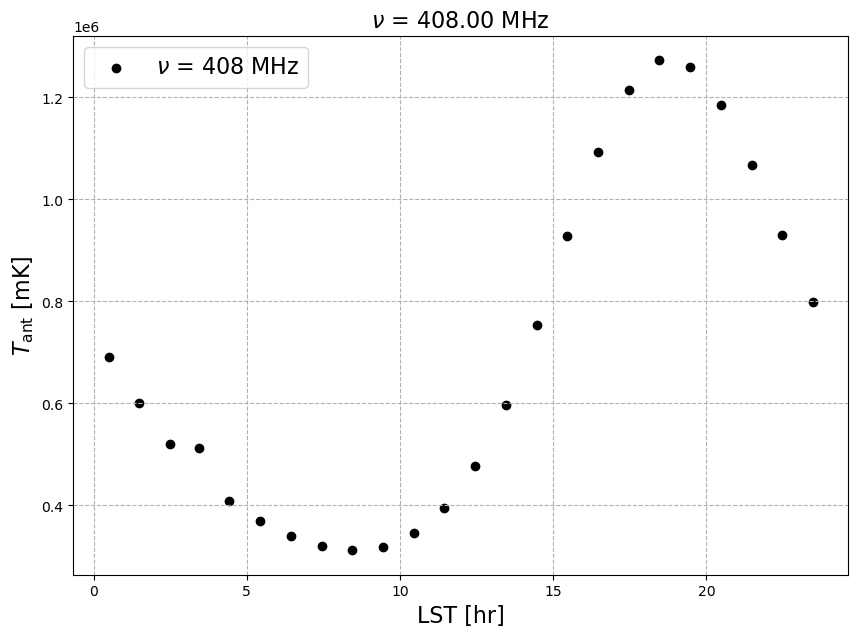

In [49]:
fig = plt.figure(figsize=(10,7))
plt.scatter(t_lst_mean,T_ant_haslam_24h,
            ls='-',marker='o',color='k',
            label=r'$\nu$ = 408 MHz')
plt.xlabel('LST [hr]', fontsize=16)
plt.ylabel(r'$T_\mathrm{ant}$ [mK]', fontsize=16)
plt.title(r'$\nu$ = '+'{:.2f} MHz'.format(408.00), fontsize=16)
plt.legend(fontsize=16)
plt.grid(ls='--')

# Extra (if have time)

## E1. Convert the Haslam map from 408 MHz to different frequency with a power law function

$T_\mathrm{sky}(\nu,\theta,\phi) = T_\mathrm{Haslam}(408~\mathrm{MHz},\theta,\phi)(\frac{\nu~\mathrm{MHz}}{408~\mathrm{MHz}})^{-\beta}$, 

where $\beta$ is called the spectral index, measured to be about 2.5 from sky survey


### Try to calulate the $T_\mathrm{ant}$ between 40-120 MHz at for all 24 hour LST
Assuming the Gaussian beam is the same for all frequencies. A real antenna beam will change with frequency though. 


In [50]:
del_nu_mhz = 1.0 # Frequency resolution in MHz
nu_sim_mhz = np.arange(40.,120.,del_nu_mhz)
T_ant_arr = np.zeros([len(t_lst_mean),len(nu_sim_mhz)])

beta = 2.5 # Spectral index (derived from other observations in the literature)

for tt in tqdm(range(len(t_lst_mean))):
    T_ant_arr[tt,:] = T_ant_haslam_24h[tt]*(nu_sim_mhz/408.00)**(-beta)


100%|██████████████████████████████████████| 24/24 [00:00<00:00, 22022.16it/s]


### Overplot the $T_\mathrm{ant}$ as a function of frequency for different LST in 1D plots


100%|████████████████████████████████████████| 24/24 [00:00<00:00, 410.54it/s]


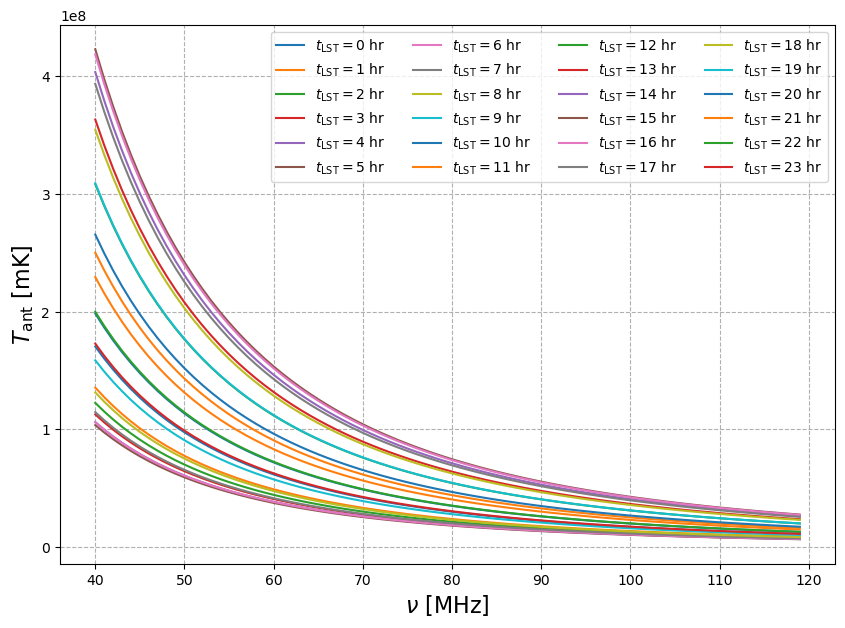

In [55]:
fig = plt.figure(figsize=(10,7))

for tt in tqdm(range(len(t_lst_mean))):
    plt.plot(nu_sim_mhz,T_ant_arr[tt,:],
                ls='-',
                label=r'$t_\mathrm{LST} = $'+ '{:d} hr'.format(tt))
plt.xlabel(r'$\nu$ [MHz]', fontsize=16)
plt.ylabel(r'$T_\mathrm{ant}$ [mK]', fontsize=16)
plt.grid(ls='--')
plt.legend(ncol=4)

### Make waterfall plot of the 24 hour observation at 1 hr resolution

Text(0, 0.5, '$t_\\mathrm{LST}$ [Hr]')

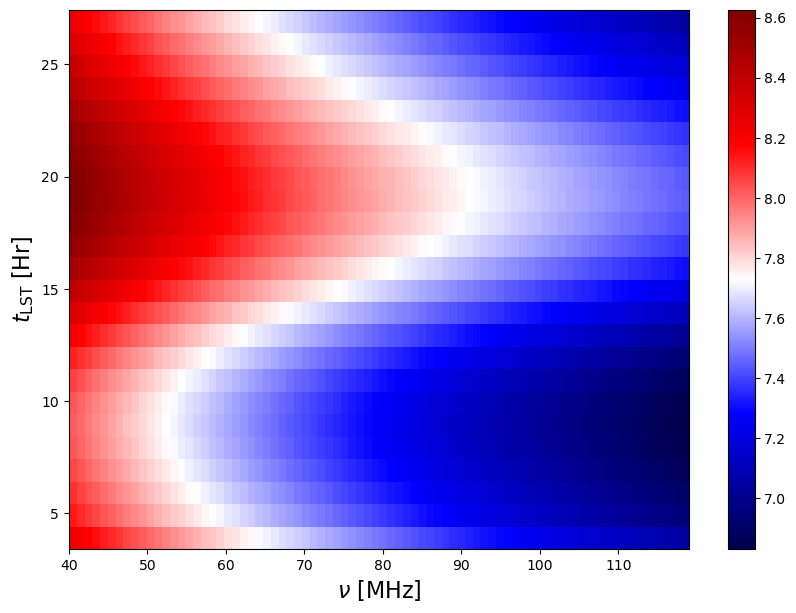

In [64]:
fig = plt.figure(figsize=(10,7))

im1 = plt.imshow(np.log10(T_ant_arr),aspect="auto",
                 cmap='seismic', extent=(nu_sim_mhz[0],
                                         nu_sim_mhz[-1],
                                         t_lst_mean[0].value,
                                         t_lst_mean[0].value+24),
                 origin="lower",interpolation="none")#,
                 #vmin=,vmax=)
cbar1 = fig.colorbar(im1)
cbar1.set_label(r'[%s]'%plot_unit, fontsize=12,rotation=270,labelpad=15)
plt.xlabel(r'$\nu$ [MHz]',fontsize=16)
plt.ylabel(r'$t_\mathrm{LST}$ [Hr]',fontsize=16)

### Make waterfall plot of the 24 hour observation at 15-min resolution
Need to regenerate the sky simulation